Name: Holly Kular\
Date: 03-19-2024\
Email: hkular@ucsd.edu\
decode_L1.m\
Description: Script for decoding analysis on layer 1 of probabilistic RNN

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sys
import os
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.svm import SVC  
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import make_classification
from scipy.optimize import curve_fit
from scipy.io import loadmat

In [216]:
# MODIFY HERE
# what conditions were the RNNs trained on?
RNN_params = {}
RNN_params['prob_split'] = '70_30'
RNN_params['afc'] = 2
RNN_params['coh'] = 'lo'
RNN_params['feedback'] = False
RNN_params['thresh'] = [.3,.7]

# Decoding params
D_params = {}
D_params['time_avg'] = False
D_params['t_win'] = [200,-1]
D_params['n_cvs'] = 5
D_params['num_cgs'] = 30
D_params['label'] = 'stim' # 'stim' or 'choice'
D_params['units'] = 'all' # 'all' or 'exc' or 'inh'
D_params['pred'] = 'unexpected' # 'expected' or 'unexpected', 'all' trials had stim 0 or 1 dominant

# Timing of task
task_info = {}
task_info['trials'] = 1000
task_info['trial_dur'] = 250  # trial duration (timesteps)
task_info['stim_on'] = 80
task_info['stim_dur'] = 50
# decode opts
time_avg = False # do we want to look at average over time window?
if time_avg:
    t_win = [ 200,-1 ]
n_cvs = 5
window = 50
# store the accuracy
acc = np.full( ( n_cvs ), np.nan )

# penalties to eval
num_cgs = 30
Cs = np.logspace( -5,1,num_cgs )

# set up the grid
param_grid = { 'C': Cs, 'kernel': ['linear'] }

# define object - use a SVC that balances class weights (because they are biased, e.g. 70/30)
# note that can also specify cv folds here, but I'm doing it by hand below in a loop
grid = GridSearchCV( SVC(class_weight = 'balanced'),param_grid,refit=True,verbose=0 )

# Data Directory
# Load data
if sys.platform.startswith('linux'):
    data_dir = f"/mnt/neurocube/local/serenceslab/holly/RNN_Geo/data/rdk_{RNN_params['prob_split']}_{RNN_params['afc']}afc/feedforward_only/{RNN_params['coh']}_coh"
else:
    data_dir = f"/Volumes/serenceslab/holly/RNN_Geo/data/rdk_{RNN_params['prob_split']}_{RNN_params['afc']}afc/feedforward_only/{RNN_params['coh']}_coh"

# Chose the model
mat_files = [f for f in os.listdir(data_dir) if f.endswith('.mat')]# Get all the trained models (should be 40 .mat files)
model_path = os.path.join(data_dir, mat_files[0]) 
model = loadmat(model_path) # model.keys()

# Change this if we want a different number of trials and different default stim (0 is the one RNN was trained on)
data_file1 = f"{data_dir}/Trials{task_info['trials']}_model{model_path[-7:-4]}_0expected.npz"
data_file2 = f"{data_dir}/Trials{task_info['trials']}_model{model_path[-7:-4]}_1unexpected.npz"
data1 = np.load(data_file1)
data2 = np.load(data_file2)


In [217]:
# Decode trials: RNN stim presented

# get the data from layer 1 decode stim
# this is a [trial x time step x unit] matrix
# filter by trial type
if D_params['pred'] == 'expected':
    #data_d = np.concatenate((data1['fr1'][data1['labs'].flatten() == 0], data2['fr1'][data2['labs'].flatten() == 0]), axis = 0)
    #labs = np.concatenate((data1['labs'][data1['labs'] == 0].squeeze(), data2['labs'][data2['labs'] == 0].squeeze()), axis = 0)
    data_d = data1['fr1']
    labs = data1['labs'].squeeze()
elif D_params['pred'] == 'unexpected':
    #data_d = np.concatenate((data1['fr1'][data1['labs'].flatten() == 1], data2['fr1'][data2['labs'].flatten() == 1]), axis = 0)
    #labs = np.concatenate((data1['labs'][data1['labs'] == 1].squeeze(), data2['labs'][data2['labs'] == 1].squeeze()), axis = 0)
    data_d = data2['fr1']
    labs = data2['labs'].squeeze()
elif D_params['pred'] == 'all':
    data_d = np.concatenate((data1['fr1'], data2['fr1']), axis = 0)
    labs = np.concatenate((data1['labs'].squeeze(), data2['labs'].squeeze()), axis = 0)


# get some info about structure of the data
tris = data_d.shape[0]             # number of trials
tri_ind = np.arange(0,tris)      # list from 0...tris
hold_out = int( tris / n_cvs )   # how many trials to hold out


In [54]:
def sliding_window(elements, window_size):
  if len(elements) <= window_size:
    return elements

  windows = []
  for i in range(len(elements) - window_size + 1):
    windows.append(elements[i:i + window_size])

  return windows

In [55]:
def update_progress(progress, total):
    bar_length = 20  # Adjust this for desired bar length
    filled_length = int(round(progress / total * bar_length))
    bar = '=' * filled_length + '-' * (bar_length - filled_length)
    print(f'Progress: [{bar}] {progress}/{total}', end='\r')

In [ ]:
# Do decoding - no parallel choice because no thresh
decoding_acc = np.zeros((len(range(task_info['stim_dur']+task_info['stim_on'],task_info['trial_dur'])),))

times = sliding_window(range(task_info['stim_dur']+task_info['stim_on'],task_info['trial_dur']), window)
counter = 0
total_iterations = task_info['trial_dur'] * n_cvs
for t in times:

  # Get data slice for the current window avg
    data_slice = np.mean( data_d[:,t, :], axis = 1 )

    # loop over cvs and do classification
    for i in range(n_cvs):

        # trials to hold out as test set on this cv fold
        tst_ind = tri_ind[ i*hold_out : (i+1)*hold_out ]

        # index into the training data on this cv fold
        trn_ind = np.setdiff1d( tri_ind, tst_ind )

        # get the training data (X) and the training labels (y)
        X = data_slice[trn_ind,:]
        y = labs[trn_ind]

        # fit the model
        grid.fit( X,y )

        # progress report
        #print(f'CV: {i}, {grid.best_estimator_}')

        # get the test data (X) and the test labels (y)
        X_test = data_slice[tst_ind, :]
        y_test = labs[tst_ind]

        # predict!
        acc[ i ] = grid.score( X_test,y_test )
        update_progress((counter * n_cvs) + i + 1, total_iterations)
    counter +=1
    decoding_acc[counter] = np.mean(acc)        
        
print(f'done decoding')

In [218]:
# Do decoding - yes parallel
from fnc_fit_and_score import fnc_fit_and_score
from multiprocessing import Pool
label = D_params.get('label', 'stim')
thresh = RNN_params.get('thresh', [.3, .7])
if label == "choice":
    times = sliding_window(range(task_info['stim_dur']+task_info['stim_on'],task_info['trial_dur']), window)
elif label == "stim":
    times = sliding_window(range(0,task_info['trial_dur']), window)
pool = Pool(processes=round(os.cpu_count() * .7))
with pool:  # use 70% of cpus
    results = pool.starmap(fnc_fit_and_score, [
        (t, np.mean( data_d[:,t, :], axis = 1 ), tri_ind, hold_out, n_cvs, labs, label, thresh, grid)
        for t in times
    ], chunksize = 10)

# Process the results from each worker process (list of lists of accuracies)
decoding_acc = np.mean(np.array(results), axis=1)
print(f'done decoding')

done decoding


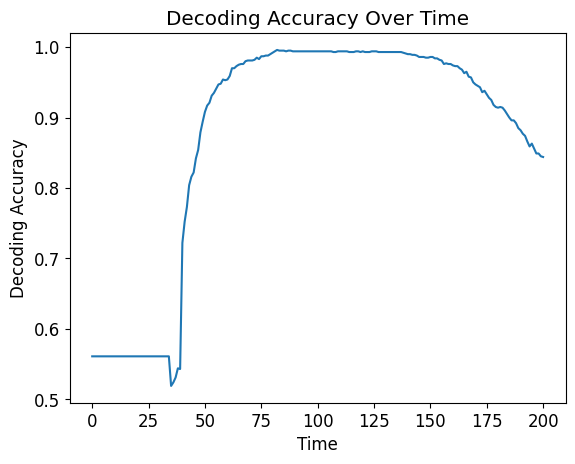

In [220]:
# Plot decoding accuracy over time
plt.figure()
plt.plot(decoding_acc)
plt.xlabel('Time')
plt.ylabel('Decoding Accuracy')
plt.title('Decoding Accuracy Over Time')
#plt.savefig(f"{data_dir}/decode_stim_exp.png")
plt.show()  

In [179]:
# start storing all decoding accuracy results

#------------- hi coh 6afc opts ignoring inh vs exc for now
#results_all['hi']['6afc']['choice']['expected']['all units']  hi_6afc_choice_exp_all DONE
#results_all['hi']['6afc']['choice']['unexpected']['all units'] hi_6afc_choice_unxp_all DONE
#results_all['hi']['6afc']['stim']['expected']['all units'] hi_6afc_stim_exp_all DONE redo
#results_all['hi']['6afc']['stim']['unexpected']['all units'] hi_6afc_stim_unxp_all DONE redo

#-------------- hi coh 2afc opts ignoring inh vs exc for now
#results_all['hi']['2afc']['choice']['expected']['all units'] DONE
#results_all[['hi']'2afc']['choice']['unexpected']['all units'] DONE
#results_all['hi']['2afc']['stim']['expected']['all units'] DONE redo hi_2afc_stim_exp_all 
#results_all['hi']['2afc']['stim']['unexpected']['all units'] DONE redo hi_2afc_stim_unxp_all 


#------------- lo coh 6afc opts ignoring inh vs exc for now
# results_all['lo']['6afc']['choice']['expected']['all units'] DONE
#results_all['lo']['6afc']['choice']['unexpected']['all units'] DONE
#results_all['lo']['6afc']['stim']['expected']['all units'] DONE redo lo_6afc_stim_exp_all 
#results_all['lo']['6afc']['stim']['unexpected']['all units'] DONE redo lo_6afc_stim_unxp_all 

#-------------- lo coh 2afc opts ignoring inh vs exc for now
#results_all['lo']['2afc']['choice']['expected']['all units'] DONE 
#results_all[['lo']'2afc']['choice']['unexpected']['all units'] DONE
#results_all['lo']['2afc']['stim']['expected']['all units'] DONE redo lo_2afc_stim_exp_all 
#results_all['lo']['2afc']['stim']['unexpected']['all units'] DONE redo lo_2afc_stim_unxp_all ip

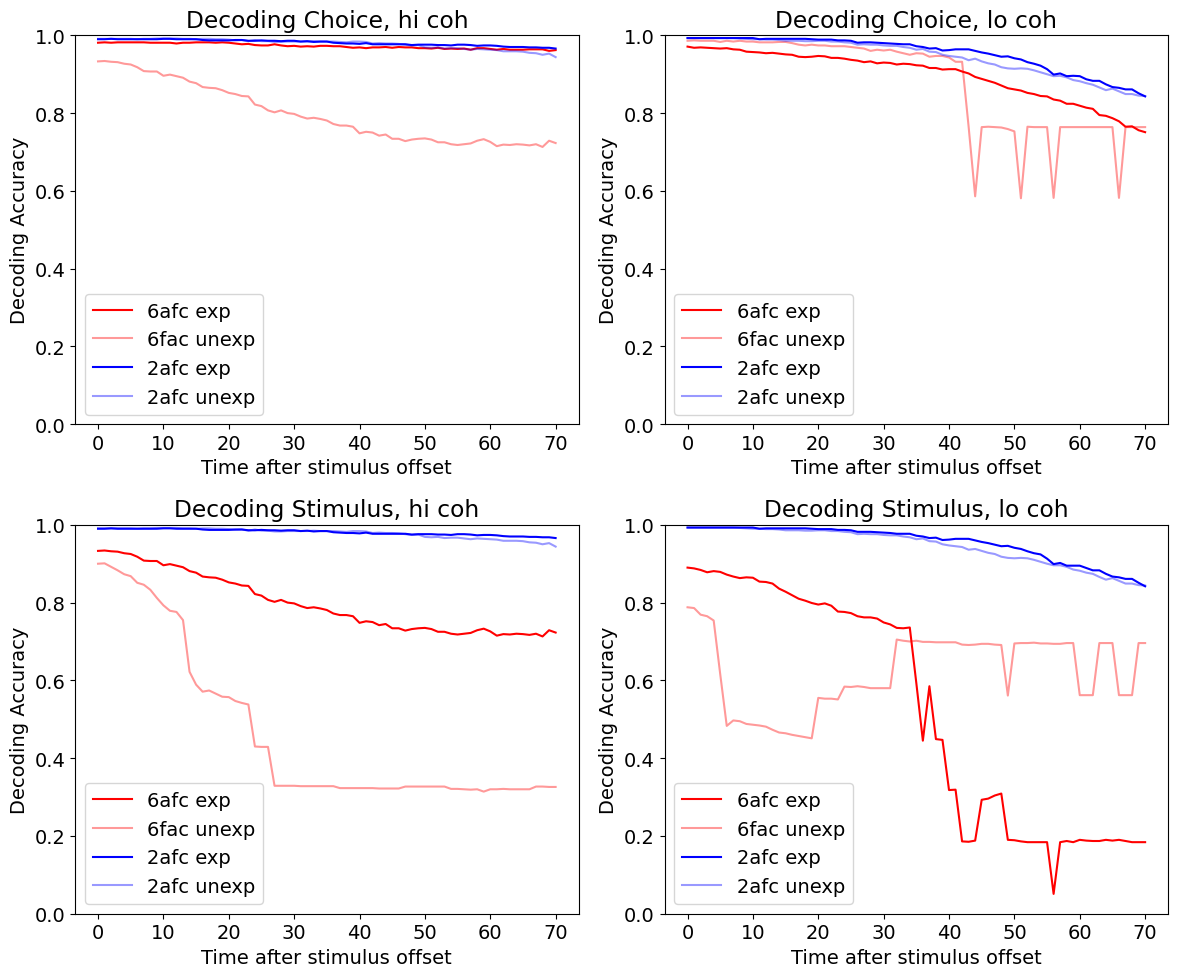

In [215]:
# plots
fig, axs = plt.subplots(2, 2, figsize=(12, 10))

# Plot 1
axs[0, 0].plot(hi_6afc_choice_exp_all, color='red', label='6afc exp')
axs[0, 0].plot(hi_6afc_choice_unxp_all, color='red', alpha=0.4, label='6fac unexp')
axs[0, 0].plot(hi_2afc_choice_exp_all, color='blue', label='2afc exp')
axs[0, 0].plot(hi_2afc_choice_unxp_all, color='blue', alpha=0.4, label='2afc unexp')
axs[0, 0].set_xlabel('Time after stimulus offset')
axs[0, 0].set_ylabel('Decoding Accuracy')
axs[0, 0].set_title('Decoding Choice, hi coh')
axs[0, 0].set_ylim(0, 1)
axs[0, 0].legend()

# Plot 2
axs[0, 1].plot(lo_6afc_choice_exp_all, color='red', label='6afc exp')
axs[0, 1].plot(lo_6afc_choice_unxp_all, color='red', alpha=0.4, label='6fac unexp')
axs[0, 1].plot(lo_2afc_choice_exp_all, color='blue', label='2afc exp')
axs[0, 1].plot(lo_2afc_choice_unxp_all, color='blue', alpha=0.4, label='2afc unexp')
axs[0, 1].set_xlabel('Time after stimulus offset')
axs[0, 1].set_ylabel('Decoding Accuracy')
axs[0, 1].set_title('Decoding Choice, lo coh')
axs[0, 1].set_ylim(0, 1)
axs[0, 1].legend()

# Plot 3
axs[1, 0].plot(hi_6afc_stim_exp_all, color='red', label='6afc exp')
axs[1, 0].plot(hi_6afc_stim_unxp_all, color='red', alpha=0.4, label='6fac unexp')
axs[1, 0].plot(hi_2afc_stim_exp_all, color='blue', label='2afc exp')
axs[1, 0].plot(hi_2afc_stim_unxp_all, color='blue', alpha=0.4, label='2afc unexp')
axs[1, 0].set_xlabel('Time after stimulus offset')
axs[1, 0].set_ylabel('Decoding Accuracy')
axs[1, 0].set_title('Decoding Stimulus, hi coh')
axs[1, 0].set_ylim(0, 1)
axs[1, 0].legend()

# Plot 4
axs[1, 1].plot(lo_6afc_stim_exp_all, color='red', label='6afc exp')
axs[1, 1].plot(lo_6afc_stim_unxp_all, color='red', alpha=0.4, label='6fac unexp')
axs[1, 1].plot(lo_2afc_stim_exp_all, color='blue', label='2afc exp')
axs[1, 1].plot(lo_2afc_stim_unxp_all, color='blue', alpha=0.4, label='2afc unexp')
axs[1, 1].set_xlabel('Time after stimulus offset')
axs[1, 1].set_ylabel('Decoding Accuracy')
axs[1, 1].set_title('Decoding Stimulus, lo coh')
axs[1, 1].set_ylim(0, 1)
axs[1, 1].legend()

# Adjust layout
plt.tight_layout()
plt.rcParams.update({'font.size': 12})

plt.savefig(f"{data_dir}/all_plots.png")

In [208]:
full_file = '/mnt/neurocube/local/serenceslab/holly/RNN_Geo/data/decoding/results_all_units.npz'
np.savez(full_file, hi_6afc_choice_exp = hi_6afc_choice_exp_all, hi_6afc_choice_unxp = hi_6afc_choice_unxp_all, hi_6afc_stim_exp = hi_6afc_stim_exp_all, hi_6afc_stim_unxp = hi_6afc_stim_unxp_all,\
        lo_6afc_choice_exp = lo_6afc_choice_exp_all, lo_6afc_choice_unxp = lo_6afc_choice_unxp_all, lo_6afc_stim_exp = lo_6afc_stim_exp_all, lo_6afc_stim_unxp = lo_6afc_stim_unxp_all,\
hi_2afc_choice_exp = hi_2afc_choice_exp_all, hi_2afc_choice_unxp = hi_2afc_choice_unxp_all, hi_2afc_stim_exp = hi_2afc_stim_exp_all, hi_2afc_stim_unxp = hi_2afc_stim_unxp_all,\
lo_2afc_choice_exp = lo_2afc_choice_exp_all, lo_2afc_choice_unxp = lo_2afc_choice_unxp_all, lo_2afc_stim_exp = lo_2afc_stim_exp_all, lo_2afc_stim_unxp = lo_2afc_stim_unxp_all)